# Displacement surge models

Will there be a displacement crisis for country x this/next year? We look to answer this question by treating it as a classification problem. A crisis is defined if displacement surges beyond a certain threshold. Looking at data from 25 countries, we train a classifier to predict if there will be a surge or not.


In [136]:
import os
import json
import pandas as pd
import numpy as np
from time import time
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.image as mpl_image
import matplotlib.pyplot as plt

%matplotlib inline 
sns.set(style="white")

In [137]:
start_time = time()
with open("../configuration.json", 'rt') as infile:
    config = json.load(infile)


sources = [os.path.join("..", config['paths']['output'], 
                        d['name'], 
                        'data.csv') for d in config['sources'] if d['name']]


# Generate a data frame with all indicators
df = pd.concat((pd.read_csv(f) for f in sources), sort=False, ignore_index=True)

# Summary stats
print("Sources            : {}".format(len(sources)))
print("Shape              : {} (rows) {} (columns)".format(*df.shape))
print("Geographies        : {}".format(len(df['Country Name'].unique())))
print("Indicators         : {}".format(len(df['Indicator Code'].unique())))
print("Temporal coverage  : {} -> {}".format(df.year.min(), df.year.max()))
print("Null values        : {}".format(sum(df['value'].isnull())))

print("\nLoaded data in {:3.2f} sec.".format(time() - start_time))


# Now arrange data in wide form
data = pd.pivot_table(df, index=['Country Code', 'year'],
                      columns='Indicator Code', values='value')

# Consider country/year as features (and not an index)
data.reset_index(inplace=True)

print("Long form of size  : {} (rows) {} (columns)".format(*data.shape))


subglobal = ['SYR','COL','AFG','COG','SSD','SOM','VEN','ETH','SDN','NGA',
             'IRQ','YEM','UKR','MMR','CAF','CMR','ERI','BDI','GEO','MLI',
             'TCD','LBY','NER','BFA','COD']
# data filtering

# Spatial filter
c1 = data['Country Code'].isin(subglobal)

# Temporal filter
c2 = data['year'] >= 1980


data = data[c1 & c2]
print("Filtered data of size  : {} (rows) {} (columns)".format(*data.shape))


# Get a look up table of indicators to use for the explainer
grp = (df
        .groupby(['Indicator Code', 'Indicator Name'])['year']
        .count()
        .reset_index()
        .drop(columns='year')
        .set_index('Indicator Code').to_dict())

INDICATORS = grp['Indicator Name']

Sources            : 19
Shape              : 924558 (rows) 6 (columns)
Geographies        : 568
Indicators         : 142
Temporal coverage  : 1789 -> 2019
Null values        : 1421

Loaded data in 1.22 sec.
Long form of size  : 35901 (rows) 144 (columns)
Filtered data of size  : 1000 (rows) 144 (columns)


In [138]:
data.head()

Indicator Code,Country Code,year,ACLED.COUNT,ACLED.FATALITIES,ADESA,AG.PRD.FOOD.XD,AG.PRD.LVSK.XD,DRC.TOT.DISP,EG.ELC.ACCS.ZS,EMDAT.CPX.OCCURRENCE,...,WHO.EXT.HTLTH.EXP,WHO.INF.DTH,WHO.MAT.DEATHS,WHO.MAT.MORT.RATIO,WHO.NEO.DTH,WHO.NUM.TB.CAS,WHO.OOP.HLTH.EXP,WHO.TB.CAS,WHO.TB.TMT.COV,WHO.UND.FIV.DTH
266,AFG,1980,NaN,NaN,NaN,78.64,70.84,1734921.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
267,AFG,1981,NaN,NaN,NaN,78.45,72.86,3879984.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
268,AFG,1982,NaN,NaN,NaN,77.60,73.31,4488214.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
269,AFG,1983,NaN,NaN,NaN,75.83,71.89,4712735.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
270,AFG,1984,NaN,NaN,NaN,72.97,68.09,4417651.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Target variable

Since we have data on several countries, we normalize the target variable such that the propensity for a surge in displacement is relative to population. 

We look at total displacement per 100K inhabitants. 

To look at binary outcomes, we further use a threshold of 8K per 100K displaced to assume there has been a surge.

In [140]:
import seaborn as sns
import matplotlib.pyplot as plt

data['TARGET'] = 100000 * data['DRC.TOT.DISP'] / data["SP.POP.TOTL"]

tmp = data.set_index(['Country Code', 'year'])
x = tmp.loc[~pd.isnull(tmp['TARGET']), 'TARGET']
x = x.sort_values(ascending=False)
x.head(10)

Country Code  year
SYR           2017    77618.944502
              2018    76429.396101
              2016    68999.422652
AFG           1990    67184.080511
              1988    65613.519705
SYR           2015    65161.311007
AFG           1987    64731.078387
              1989    64403.641558
              1991    62458.007235
SYR           2014    61841.359477
Name: TARGET, dtype: float64

So Syria in 2017 had the highest displaced stock (77.6% of total population). The UNHCR considers displacement greater than 25K to be a crisis. DRC specified 75K (new displacement) as the threshold. We had 153 instances for the latter threshold. 

Since we normalize by population, what is an appropriate threshold where we get roughly 153 surge events?

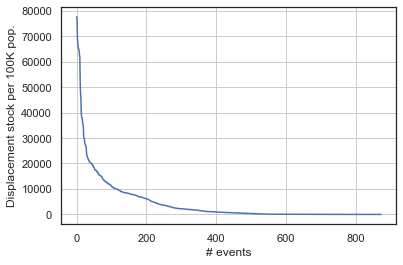

In [5]:
plt.plot(x.values)
plt.ylabel("Displacement stock per 100K pop.")
plt.xlabel("# events")
plt.grid(True);

In [6]:
sum(x>8000)

154

So a per-capita threshold of 8K is comparable to one of 75K new total displacement stock (in terms of number of displacement crisis).

In [141]:
# Binary outcomes (displacement or no displacement) based on 
# if total *new* displacement for the year exceeds this threshold

DRC_THRESHOLD = 75000
PER_100K_THRESHOLD = 8000

def target_outcomes_old(x):
    
    x = x.sort_values(by='year')
    x.set_index('year', inplace=True)
    new_stock = x['DRC.TOT.DISP'].diff()
    return new_stock > DRC_THRESHOLD
    

#d = data.groupby(['Country Code']).apply(target_outcomes)
#tar = d.reset_index().melt(id_vars=['Country Code'], value_vars=d.columns)
#tar.rename(columns={'value': 'TARGET'}, inplace=True)
#data = data.merge(right=tar, on=['Country Code', 'year'])

data['TARGET'] = data.TARGET > PER_100K_THRESHOLD

# Features

Two variants: We can consider *all* features from the dataset or just the ones used by the causal model. 

In [7]:
# Variant 1: All features
idx = ['Country Code', 'year']
mm = ['ETH.TO.{}'.format(i) for i in ['DNK', 'GBR', 'ITA', 'SAU', 'SWE', 'ZAF']]
endo = ['UNHCR.OUT.AS', 'UNHCR.OUT.IDP', 'UNHCR.OUT.OOC', 
        'UNHCR.OUT.REF', 'UNHCR.OUT.RET', 'UNHCR.OUT.RETIDP', 'IDP', "UNHCR.EDP"]
# missing entirely
emdat = ['EMDAT.CPX.OCCURRENCE','EMDAT.CPX.TOTAL.DEATHS','EMDAT.CPX.TOTAL.AFFECTED','EMDAT.CPX.AFFECTED']

# AIX Feature errors
aix_ex = []# ['SP.PV.INT.VIOL', 'SP.PV.INDP']

# low coverage
low_cov = ['UC.FAT.RAKH',
'UC.EVT.RAKH',
'WFP.PRC.WHT',
'ER.GDP.FWTL.M3.KD',
'WHO.MAT.MORT.RATIO',
'WHO.MAT.DEATHS',
'SE.ADT.LITR.ZS',
'SI.POV.GINI',
'ER.H2O.INTR.PC',
'IQ.CPA.PROP.XQ',
'EN.ATM.PM25.MC.M3']
target = ['DRC.TOT.DISP', 'TARGET']
allfeatures = list(set(data.columns.tolist()) - set(idx + mm + endo + target + emdat + aix_ex))

mmr_data = [f for f in allfeatures if f.startswith('MMR.NSO')]

features =  list(set(allfeatures) - set(mmr_data))
print("# Features: {}".format(len(features)))

# Features: 110


In [31]:
# Variant 2: a subset
with open("../model/bayesnetwork/network.json", 'rt') as infile:
    net = json.load(infile)
features = [i['code'] for i in net['indicators']]
features.remove('DRC.TOT.DISP')
print("# Features: {}".format(len(features)))

# Features: 15


# Some pre-processing

The target variable is highly-imbalanced. So resample with replacement to balance the classes.

In [61]:
data.TARGET.value_counts()

False    846
True     154
Name: TARGET, dtype: int64

In [9]:
target = 'TARGET'
X = data[features].dropna(how='all', axis=1)
y = data[target]

# Random splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

In [91]:
# OR Time-base splits
yr = 2014
test_idx = data.year > yr
train_idx = ~test_idx
X_train = data.loc[train_idx][features]
X_test = data.loc[test_idx][features]
y_train = data.loc[train_idx][target]
y_test = data.loc[test_idx][target]

In [ ]:
from imblearn.over_sampling import RandomOverSampler 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# tmp = data[features].dropna(how='all', axis=1)

ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)
y_train_res.value_counts()

# Models

Let's start with a baseline model - logistic regression.

Accuracy: 86.40%


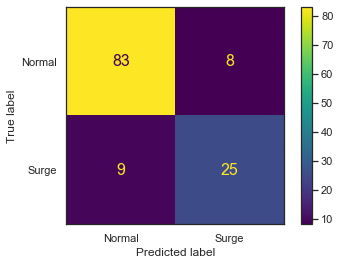

In [93]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

clf = Pipeline(steps=[('imputer', SimpleImputer()), 
                      ('preprocessor', StandardScaler()),
                      ('classifier', LogisticRegression(max_iter=500))])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Accuracy: {:2.2f}%".format(100.0*accuracy_score(y_test, y_pred)))
plt.rcParams.update({'font.size': 16})
plot_confusion_matrix(clf, X_test, y_test, display_labels=['Normal', 'Surge'], values_format='.0f');

Accuracy: 90.40%


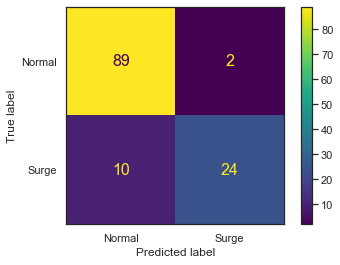

In [94]:
from sklearn.ensemble import GradientBoostingClassifier
clf = Pipeline(steps=[('imputer', SimpleImputer()), 
                      ('preprocessor', StandardScaler()),
                      ('classifier', GradientBoostingClassifier(random_state=42))])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Accuracy: {:2.2f}%".format(100.0*accuracy_score(y_test, y_pred)))
plot_confusion_matrix(clf, X_test, y_test, display_labels=['Normal', 'Surge'], values_format='.0f');

In [95]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred));

              precision    recall  f1-score   support

       False       0.90      0.98      0.94        91
        True       0.92      0.71      0.80        34

    accuracy                           0.90       125
   macro avg       0.91      0.84      0.87       125
weighted avg       0.91      0.90      0.90       125



Perhaps interesting to see:
- can we explain why we can capture a majority of these events?
- this is like a 'nowcast'. How would we do for future year surges?
- Would the Myanmar 2017 case be nowcasted/forecasted?

# Explainer models

In [14]:
from aix360.algorithms.rbm import FeatureBinarizer
from aix360.algorithms.rbm import BooleanRuleCG, BRCGExplainer

# AIX360 methods are not valid estimators/transformers
# So can't be used in a pipeline. First impute
imp = SimpleImputer()
X_train_fb = pd.DataFrame(imp.fit_transform(X_train))
X_train_fb.columns = X_train.columns

X_test_fb = pd.DataFrame(imp.transform(X_test))
X_test_fb.columns = X_test.columns

fb = FeatureBinarizer(negations=True)
X_train_fb = fb.fit_transform(X_train_fb)
X_test_fb = fb.transform(X_test_fb)

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_cm(true, pred, display_labels):
    """ plot confusion for non-estimators """
    
    cm  = confusion_matrix(true, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=display_labels)
    
    return disp.plot(include_values=True,
                     cmap='viridis', ax=None, xticks_rotation=None,
                     values_format='.0f')

Learning DNF rule with complexity parameters lambda0=0.001, lambda1=0.001
Initial LP solved
Iteration: 1, Objective: 0.1060
Iteration: 2, Objective: 0.0775
Iteration: 3, Objective: 0.0693
Iteration: 4, Objective: 0.0668
Iteration: 5, Objective: 0.0668
Iteration: 6, Objective: 0.0603
Iteration: 7, Objective: 0.0563
Iteration: 8, Objective: 0.0543
Iteration: 9, Objective: 0.0543
Iteration: 10, Objective: 0.0543
Iteration: 11, Objective: 0.0540
Iteration: 12, Objective: 0.0540
Accuracy: 94.00%


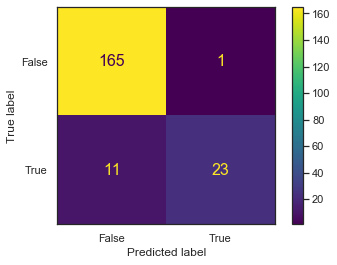

In [64]:
# Note that the explanations are sensitive to the regularization parameters
boolean_model = BooleanRuleCG(silent=False, lambda0=0.001, lambda1=0.001, CNF=False)
explainer = BRCGExplainer(boolean_model)
explainer.fit(X_train_fb, y_train)

y_pred = explainer.predict(X_test_fb)
print("Accuracy: {:2.2f}%".format(100.0*accuracy_score(y_test, y_pred)))
plot_cm(y_test, y_pred, [False, True]);

In [47]:
print(classification_report(y_test, y_pred));

              precision    recall  f1-score   support

       False       0.94      0.96      0.95       166
        True       0.80      0.71      0.75        34

    accuracy                           0.92       200
   macro avg       0.87      0.83      0.85       200
weighted avg       0.92      0.92      0.92       200



In [65]:
import re
pattern = re.compile(r'\b(' + '|'.join(INDICATORS.keys()) + r')\b')
result = pattern.sub(lambda x: INDICATORS[x.group()], rule)

e = explainer.explain()

# the labels are flipped between Conjunctive/Disjunctive normal forms
isCNF = 'No surge if ANY of the following rules are satisfied, otherwise predict surge:'
notCNF = 'Predict surge if ANY of the following rules are satisfied, otherwise no:'
print(isCNF if e['isCNF'] else notCNF)
print()
for rule in e['rules']:
    result = pattern.sub(lambda x: INDICATORS[x.group()], rule)
    print(f'  - {result}')

Predict surge if ANY of the following rules are satisfied, otherwise no:

  - Number of non-state conflict events per year <= 0.00 AND Magnitude score of episode(s) of international warfare.Scale: 1 (lowest) to 10 (highest) > 1.00
  - Fragile States Index: Group Grievance (0-10, where 10 is the most fragile) > 9.01 AND Scaled portion of country affected by fighting (range 1-4; 9=missing) > 3.00
  - CPIA property rights and rule-based governance rating (1=low to 6=high) <= 1.50 AND Price of wheat in retail <= 110.50
  - V-Dem: Freedom of religion <= -0.79 AND Tuberculosis treatment coverage <= 69.00 AND Urban population <= 9750094.92 AND Magnitude score of episode(s) of civil warfare. Scale: 1 (lowest) to 10 (highest)  > 3.00
  - Human Rights Score Mean > -2.49 AND Population ages 20-24, male (% of male population) > 8.72 AND Scaled portion of country affected by fighting (range 1-4; 9=missing) > 2.00 AND Fragile States Index: Factionalized Elites (0-10, where 10 is the most fragile) <=

### CNF result 
No surge if ANY of the following rules are satisfied, otherwise predict surge:

  - Magnitude score of episode(s) of international violence. Scale: 1 (lowest) to 10 (highest) > 0.00
  - Unemployment, female (% of female labor force) (modeled ILO estimate) <= 8.19 AND V-Dem: Exclusion by Social Group index  <= 0.56
  - Population density (people per sq. km of land area) <= 10.94 AND Number of one-sided conflict events per year <= 19.11
  - Unemployment, female (% of female labor force) (modeled ILO estimate) <= 1.60 AND Battle-related deaths (number of people) <= 577.60
  - Length of conflict in years <= 0.00 AND Fragile States Index: External Intervention (0-10, where 10 is the most fragile) <= 7.50
  - Polity Index: Revised Combined PolityScore (-10 - 10) > -8.00 AND External health expenditure (EXT) as percentage of current health expenditure (CHE) (%) > 11.06 AND Unemployment, female (% of female labor force) (modeled ILO estimate) > 19.84
  - V-Dem: Freedom of religion > -0.79 AND Fragile States Index: Economy (0-10, where 10 is the most fragile).INQ <= 7.94 AND Age dependency ratio (% of working-age population) <= 103.52 AND Fragile States Index: External Intervention (0-10, where 10 is the most fragile) > 7.50
  - Urban population > 969698.70 AND CPIA property rights and rule-based governance rating (1=low to 6=high) > 1.50 AND GDP per capita, PPP (current international $) <= 4160.77 AND Magnitude score of episode(s) of civil warfare. Scale: 1 (lowest) to 10 (highest)  <= 3.00 AND Population growth (annual %) > 1.51


## Misclassifications

Which instances were incorrectly classified?

In [96]:
from pprint import pprint

print("Misclassifications: ")
res = {}
for p, t, idx in zip(y_pred, y_test, y_test.index):
    if p != t:
        ccode = data.loc[idx]['Country Code']
        yr = data.loc[idx]['year']
        try:
            res[ccode].append(yr)
        except KeyError:
            res[ccode] = [yr]
            
pprint(res)

        
print("\nCorrectly classified: ")
res = {}
for p, t, idx in zip(y_pred, y_test, y_test.index):
    if p == t:
        ccode = data.loc[idx]['Country Code']
        yr = data.loc[idx]['year']
        try:
            res[ccode].append(yr)
        except KeyError:
            res[ccode] = [yr]
pprint(res)

Misclassifications: 
{'CAF': [2016, 2017, 2018],
 'COL': [2018],
 'GEO': [2017, 2018],
 'SDN': [2016],
 'SSD': [2018],
 'SYR': [2018],
 'VEN': [2018],
 'YEM': [2016, 2017]}

Correctly classified: 
{'AFG': [2015, 2016, 2017, 2018, 2019],
 'BDI': [2015, 2016, 2017, 2018, 2019],
 'BFA': [2015, 2016, 2017, 2018, 2019],
 'CAF': [2015, 2019],
 'CMR': [2015, 2016, 2017, 2018, 2019],
 'COD': [2015, 2016, 2017, 2018, 2019],
 'COG': [2015, 2016, 2017, 2018, 2019],
 'COL': [2015, 2016, 2017, 2019],
 'ERI': [2015, 2016, 2017, 2018, 2019],
 'ETH': [2015, 2016, 2017, 2018, 2019],
 'GEO': [2015, 2016, 2019],
 'IRQ': [2015, 2016, 2017, 2018, 2019],
 'LBY': [2015, 2016, 2017, 2018, 2019],
 'MLI': [2015, 2016, 2017, 2018, 2019],
 'MMR': [2015, 2016, 2017, 2018, 2019],
 'NER': [2015, 2016, 2017, 2018, 2019],
 'NGA': [2015, 2016, 2017, 2018, 2019],
 'SDN': [2015, 2017, 2018, 2019],
 'SOM': [2015, 2016, 2017, 2018, 2019],
 'SSD': [2015, 2016, 2017, 2019],
 'SYR': [2015, 2016, 2017, 2019],
 'TCD': [2015, 20

# Next year forecast

The above is for `current` year. How do we do for classifications for year `t + 1`?


In [142]:
def lag_variables(data, var, lag):

    idx_cols = ['year', 'Country Code']
    fv = var + idx_cols
    
    tmp = data[fv].copy(deep=True)
    
    col_name = [v + ".T" + "{0:+}".format(lag) for v in var]
    
    tmp.rename(columns={k: v for (k, v) in zip(var, col_name)},
               inplace=True)
    tmp.year -= lag
    data = pd.merge(data, tmp, on=idx_cols, how='left')
    
    return data, col_name

data2, vname = lag_variables(data, ['TARGET'], 1)
data2['TARGET'] = data2[vname]

# Drop unknown labels
#data2 = data2.dropna(subset=['TARGET'])

Accuracy: 90.40%


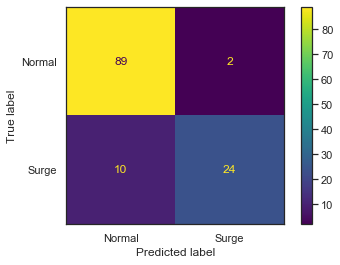

In [167]:
target = 'TARGET'
X = data2[features].dropna(how='all', axis=1)
y = data2[target]

# Drop missing labels
idx = ~y.isnull()
X = X.loc[idx]
y = y.loc[idx]
#y.loc[y.isnull()] = False

# Random splits
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

# OR Time-base splits
yr = 2014
test_idx = data.year > yr
train_idx = ~test_idx
X_train = data.loc[train_idx][features]
X_test = data.loc[test_idx][features]
y_train = data.loc[train_idx][target]
y_test = data.loc[test_idx][target]

ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)
y_train_res.value_counts()


clf = Pipeline(steps=[('imputer', SimpleImputer()), 
                      ('preprocessor', StandardScaler()),
                      ('classifier', GradientBoostingClassifier(random_state=42))])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Accuracy: {:2.2f}%".format(100.0*accuracy_score(y_test, y_pred)))
plot_confusion_matrix(clf, X_test, y_test, display_labels=['Normal', 'Surge'], values_format='.0f');

In [169]:
print("Misclassifications: ")
res = {}
for p, t, idx in zip(y_pred, y_test, y_test.index):
    if p != t:
        ccode = data.loc[idx]['Country Code']
        yr = data.loc[idx]['year']
        try:
            res[ccode].append(yr)
        except KeyError:
            res[ccode] = [yr]
            
pprint(res)

        
print("\nCorrectly classified: ")
res = {}
for p, t, idx in zip(y_pred, y_test, y_test.index):
    if p == t:
        ccode = data.loc[idx]['Country Code']
        yr = data.loc[idx]['year']
        try:
            res[ccode].append(yr)
        except KeyError:
            res[ccode] = [yr]
pprint(res)

Misclassifications: 
{'CAF': [2016, 2017, 2018],
 'COL': [2018],
 'GEO': [2017, 2018],
 'SDN': [2016],
 'SSD': [2018],
 'SYR': [2018],
 'VEN': [2018],
 'YEM': [2016, 2017]}

Correctly classified: 
{'AFG': [2015, 2016, 2017, 2018, 2019],
 'BDI': [2015, 2016, 2017, 2018, 2019],
 'BFA': [2015, 2016, 2017, 2018, 2019],
 'CAF': [2015, 2019],
 'CMR': [2015, 2016, 2017, 2018, 2019],
 'COD': [2015, 2016, 2017, 2018, 2019],
 'COG': [2015, 2016, 2017, 2018, 2019],
 'COL': [2015, 2016, 2017, 2019],
 'ERI': [2015, 2016, 2017, 2018, 2019],
 'ETH': [2015, 2016, 2017, 2018, 2019],
 'GEO': [2015, 2016, 2019],
 'IRQ': [2015, 2016, 2017, 2018, 2019],
 'LBY': [2015, 2016, 2017, 2018, 2019],
 'MLI': [2015, 2016, 2017, 2018, 2019],
 'MMR': [2015, 2016, 2017, 2018, 2019],
 'NER': [2015, 2016, 2017, 2018, 2019],
 'NGA': [2015, 2016, 2017, 2018, 2019],
 'SDN': [2015, 2017, 2018, 2019],
 'SOM': [2015, 2016, 2017, 2018, 2019],
 'SSD': [2015, 2016, 2017, 2019],
 'SYR': [2015, 2016, 2017, 2019],
 'TCD': [2015, 20

In [170]:
print(classification_report(y_test, y_pred));

              precision    recall  f1-score   support

       False       0.90      0.98      0.94        91
        True       0.92      0.71      0.80        34

    accuracy                           0.90       125
   macro avg       0.91      0.84      0.87       125
weighted avg       0.91      0.90      0.90       125

